In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import BertTokenizerFast, AutoTokenizer, AutoModel
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from langchain.embeddings import HuggingFaceEmbeddings
from torch.utils.data import Dataset, DataLoader
import lightning as pl
import torch
from torch import nn
from torch.functional import F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
from copy import copy
import string
from sklearn.metrics import f1_score, balanced_accuracy_score
from pathlib import Path
import spacy

torch.set_float32_matmul_precision('medium')

c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stephan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Introduction (Alex)

## Why we need text classification

## Approaches
- Classic machine learning (baseline)
- RNN Deep-learning
- Transformers

## Evaluation

How do we evaluate the systems

### Quantitative evaluation

On the quantitative side, we will evaluate our models on Accuracy and F1-Macro.

#### Accuracy 
The main metric we will evaluate or classification models on is accuracy, the most commonly used metric for classification problems. It indicates the percentage of correctly classified samples in relation to the total number of samples. An **advantage** of Accuracy is its simplicity and interpretability. The **disadvantage** is that it can be misleading for unbalanced data sets as it does not provide information about the performance of the model for individual classes.

$$
Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{\sum_{i=1}^{n} \text{True Positives}_i}{\sum_{i=1}^{n} (\text{True Positives}_i + \text{False Positives}_i + \text{False Negatives}_i)}
$$

##### F1-Score

Precision indicates the ratio of true positive predictions to the total number of positive predictions. Recall indicates the ratio of true positive predictions to the total number of actual positive predictions. The F1 score is the harmonic mean of precision and recall and thus forms a metric that takes both aspects into account. A **disadvantage** of precision and recall is that precision and recall must be considered separately to get a complete picture of a model's performance. An **advantage** is that models with a metric such as precision can be optimised for specific requirements from the use case. This is advantageous, for example, if the consequences of a misclassification would be particularly severe.

$$
Precision = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

$$
Recall = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

$$
F1\text{-}Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

**Macro and Micro Average**

For multiclass classification problems, precision, recall and F1-score can be calculated individually for each class and then aggregated. One way to aggregate these metrics is the Macro Average, where the metrics are calculated individually for each class and then averaged across all classes. The Micro Average, on the other hand, calculates the metrics based on the total number of True Positives, False Positives and False Negatives across all classes. Accordingly, this gives the metric a different meaning: Macro Average gives all classes the same weighting, even those with fewer samples, while Micro Average is more strongly influenced by the classes with more instances.

Macro Average:

$$
\text{Macro Average Precision} = \frac{1}{n}\sum_{i=1}^{n} Precision_i
$$
$$
\text{Macro Average Recall} = \frac{1}{n}\sum_{i=1}^{n} Recall_i
$$
$$
\text{Macro Average F1-Score} = \frac{1}{n}\sum_{i=1}^{n} F1\text{-}Score_i
$$

We will balance our dataset, so there should be no class inbalance, but actively choose the F1 Macro Average as an evaluation metric, as this still provides us with more robustness and no disadvantages.

### Qualitative evaluation

Examples on individual samples from test split and final comparison of model performane on a custom benchmark.


# Dataset (Tobias)

The dataset crafted for the chatbot merges three distinct types of data to cover a range of interactions it will encounter. From the [germanquad](https://huggingface.co/datasets/deepset/germanquad) dataset, questions are selected for their relevance to general knowledge inquiries. These are paired with texts from the [germeval18](https://huggingface.co/datasets/philschmid/germeval18) dataset, which provides examples of offensive language that the chatbot must learn to recognize and reject. To add depth, the dataset includes concern-related texts, which are sourced from the [Stress-Annotated Dataset (SAD)](https://github.com/PervasiveWellbeingTech/Stress-Annotated-Dataset-SAD) that contains English-language entries pertaining to stressors in areas such as school and work. These entries are translated into German to align with the rest of the dataset, ensuring the chatbot receives uniform input during training. For translation, a [model](https://huggingface.co/facebook/nllb-200-distilled-1.3B) from Hugging Face is used.

The purpose of a balanced training and testing set is to create a chatbot that can handle all types of prompts equally well. By having an equal number of questions, concerns, and examples of harmful content, the chatbot is less likely to become biased. It won't over-prioritize one type of prompt over another. This balance is important because it reflects the variety of inputs a chatbot will encounter once it goes live. 

## Explorative Data Analysis

In [49]:
df_train = pd.read_parquet("data/train.parquet")
df_test = pd.read_parquet("data/test.parquet")
df_benchmark = pd.read_csv("data/benchmark.csv", sep=";")

### Class balance 

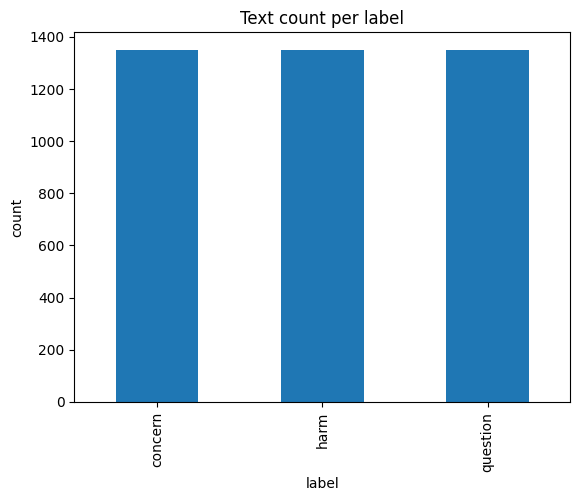

In [3]:
df_train.groupby("label").size().plot.bar()
plt.xlabel("label")
plt.ylabel("count")
plt.title("Text count per label")
plt.show()

As we can see the [build_dataset.py](build_dataset.py) handled the class balancing correctly.  
There is no class imbalance.

### Duplicates and intersection between train and test

In [4]:
print("Duplicates in train df: ", df_train.text.duplicated().sum())
print("Duplicates in test df: ", df_test.text.duplicated().sum())

print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
print("Length of train set: ", len(df_train))
print("Length of test set: ", len(df_test))

Duplicates in train df:  9
Duplicates in test df:  1
Intersection between train and test:  4
Length of train set:  4050
Length of test set:  1014


As we can see we have duplicates in the dataset.  
There are also some texts in the train and test dataset simultaneously.  
The amount of intersections and duplicates is low but for the sake of completeness they are removed.

In [5]:
#drop duplicates
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

#drop intersections from test set
df_test.drop(df_test[df_test.text.isin(np.intersect1d(df_train.text.values, df_test.text.values))].index, inplace=True)

In [6]:
print("Duplicates in train df: ", df_train.text.duplicated().sum())
print("Duplicates in test df: ", df_test.text.duplicated().sum())

print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
print("Length of train set: ", len(df_train))
print("Length of test set: ", len(df_test))

Duplicates in train df:  0
Duplicates in test df:  0
Intersection between train and test:  0
Length of train set:  4041
Length of test set:  1009


After removal no duplicates or intersections occured.

### Distribution of word count

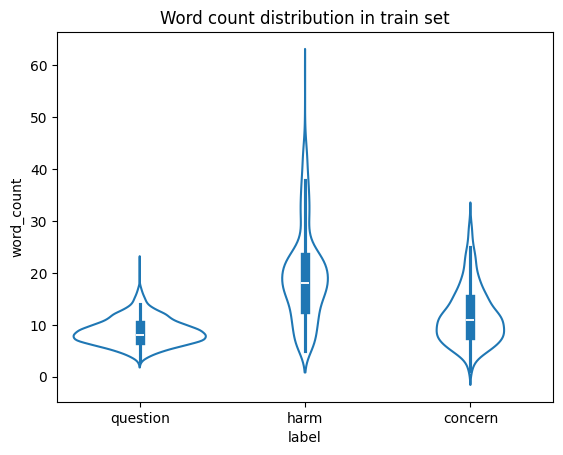

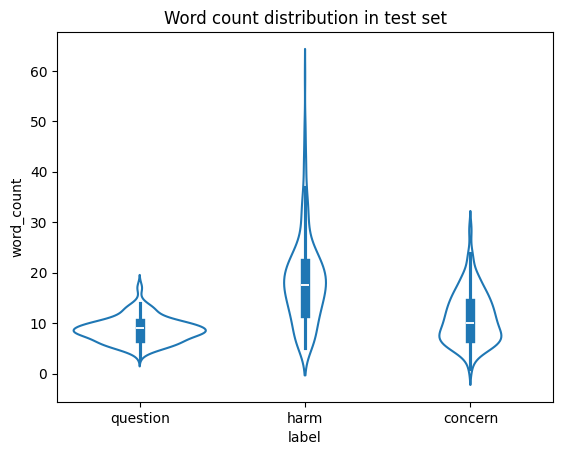

In [7]:
sns.violinplot(df_train.assign(word_count=df_train['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Word count distribution in train set")
plt.show()

sns.violinplot(df_test.assign(word_count=df_test['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Word count distribution in test set")
plt.show()

In these violin plots we can see the word count distribution of the texts grouped by class.  
Harm has the longest median word count per text with a massive tail.  
Question has the smallest variance in word count compared to harm and concern.

### Qualitative 

In [8]:
for label, df in df_train.groupby("label"):
    print(label + ":")
    display(df.sample(10, random_state=1).text.to_list())

concern:


['Ich werde sehr müde von der scharfen Art, wie sie uns an unseren Jobs anpassen wollen.',
 'Ja, ich hatte harte Zeiten. Ich hatte mit einem alkoholischen, missbräuchlichen Vater zu tun.',
 'Ich habe meinen Job verloren, also weiß ich nicht, wie die Miete bezahlt wird.',
 'Ich arbeite wegen Covid nicht, also fühlt sich alles stressig an.',
 'Ich mache mir Sorgen um meine Eltern, habe seit 2 Wochen nicht mit meinem Dad gesprochen.',
 'Ich kann nicht mit der Krankheit meines kleinen Bruders umgehen.',
 'Außerdem bin ich sehr deprimiert und fühle mich gestresst wegen der Arbeit und der Suche nach einem neuen Job.',
 'Danke für die Frage. Zu viel Arbeit und so wenig Zeit.',
 'Meine Noten und einen Kurs, den ich im Moment nicht mehr bewältigen kann.',
 'Mein Vorgesetzter drängt mich derzeit sehr, Berichte einzureichen.']

harm:


['Hubertus....was hab ich mit Adolf zu tun? LBR Und ich erstarre bei beim Wort Nazi auch nicht in Schuldgefühlen wie der Rest nur weil ichliebe',
 'Politiker gleichbedeutend mit BERUFSLÜGNER richten gerade irreparable Schäden für unser Land Europa und die Welt an und Mio schauen zu ',
 'Sie Gabriel und Merkel mit ihrem antirussischen Gelaber und ihrer MassenIslamisierung bringen uns in Kriegsgefahr!',
 'Wenn die Grünen Stinktiere in Deutschland verschwinden im September wird Deutschlands Luft enorm besser werden!',
 'Das ist die Vorankündigung der Merkel Vasallen wie den Bürger noch mehr Geld aus der Tasche gezogen werden soll um die Flüchtlinge zu finan.',
 'Türken die sich die österreichische Staatsbürgerschaft erschlichen haben LBR müssen aufgedeckt und verurteil werden. Davonjagen.',
 'Dem Kommentar entnehme ich das auch ihre Schaukel als Kind zu nahe an der Wand gestanden hat.',
 'Was ist denn mit unseren Generälen los ??Bei dem UNRECHTSSYSTEM wäre doch mal ein Militärputsch schön

question:


['An wessen Geschichte ist der Film Dreamgirls angelehnt?',
 'Welche Rolle spielen Indizes bei der Abfrageoptimierung in Datenbanksystemen?',
 'Mit wem hatte Madonna ihr erste Tochter?',
 'Wie viele Menschen in den USA sind jüdischen Glaubens?',
 'Wie kann man Jagd- von Tiermalerei unterscheiden?',
 'Aus welchen Teilen besteht die Uniform der Spieler im Canadian Football?',
 'Für welche Katastrophe öffnete die Sowjetunion das erste mal die Grenzen für internationale Hilfe? ',
 'Mit welchem Grund lehnte man die Rechtschreibung von Siegenbeek in Belgien ab? ',
 'Was brauchen Hunde um Farben sehen zu können?',
 'Welche Bakterien bilden Flagellen?']

### Wordcloud

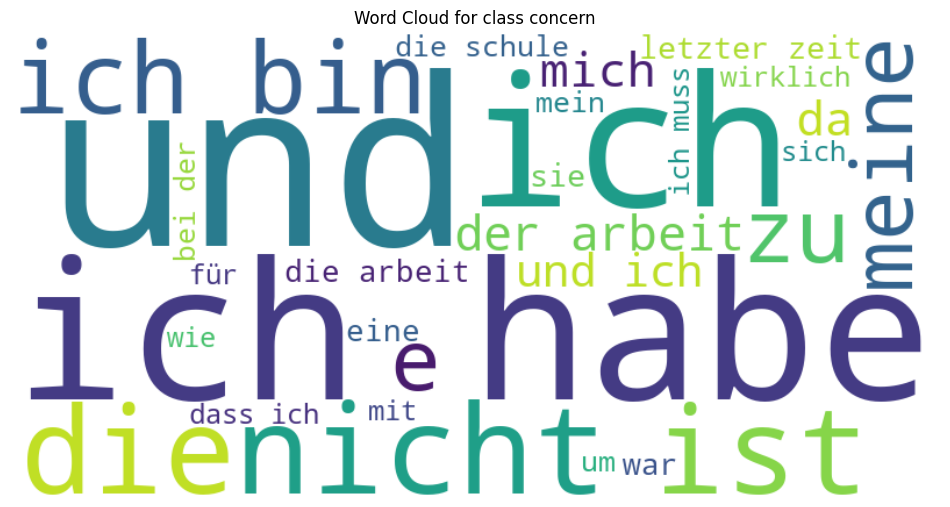

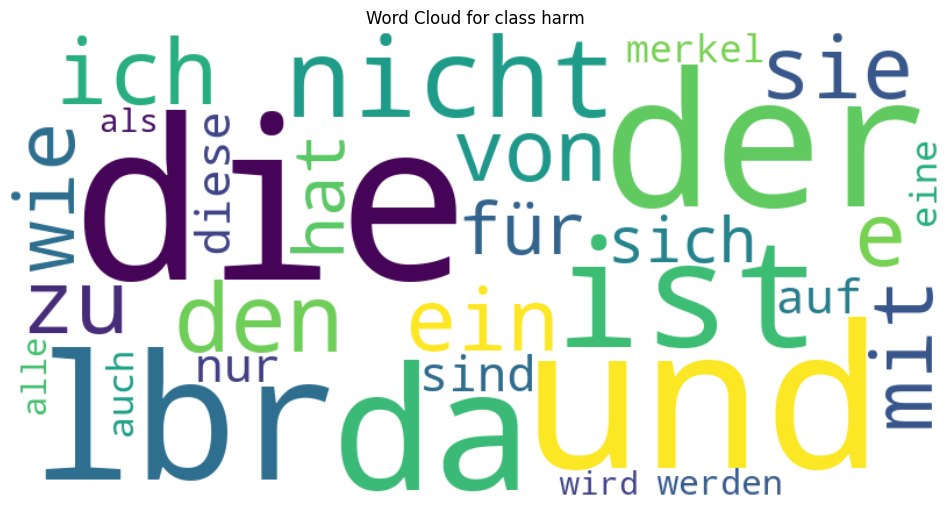

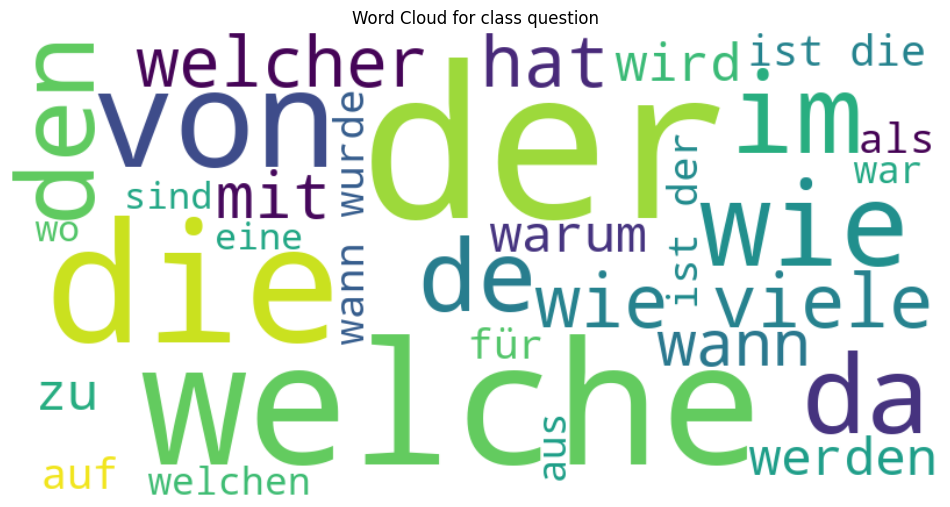

In [9]:
#!python -m spacy download de_core_news_sm

def generate_count_wordclouds(df:pd.DataFrame, top_n_words=30):
    nlp = spacy.load("de_core_news_sm")

    # create custom tokenizer that removes punctuation, spaces and non-alphabetic characters
    def spacy_tokenizer(doc):
        with nlp.disable_pipes(*["ner", "parser", "tagger"]):
            return [t for t in nlp(doc) if not t.is_punct and not t.is_space]

    for label, df in df.groupby("label"):
        tokens = df.text.apply(spacy_tokenizer)
        lowercase_tokens = [token.lower_ for doc in tokens for token in doc]

        # create wordcloud
        wordcloud = WordCloud(
            width=800, height=400, background_color="white", max_words=top_n_words
        ).generate(" ".join(lowercase_tokens))

        # show wordcloud
        plt.figure(figsize=(12, 10))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Word Cloud for class {label}')
        plt.show()


generate_count_wordclouds(df_train)

### Topic modelling

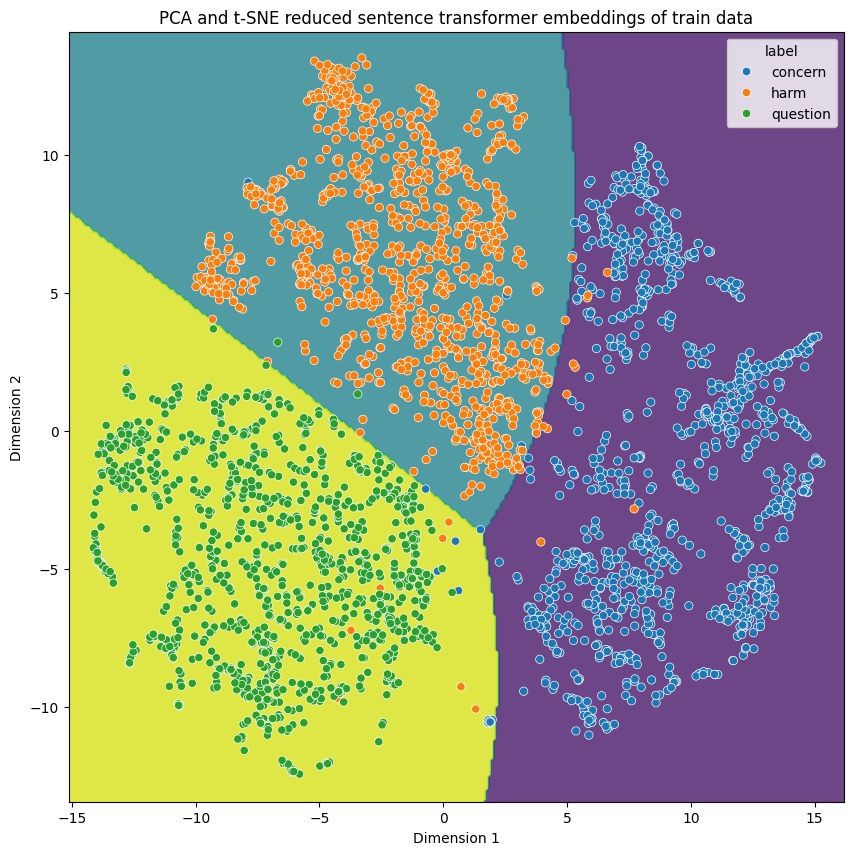

In [35]:
def tsne_reduction(df:pd.DataFrame, pca_dim=50, perplexity=30, learning_rate=200, seed=1234):
    #make a copy
    df = df.copy()

    #create embeddings
    embeddings = np.array(HuggingFaceEmbeddings(model_name="sentence-transformers/distiluse-base-multilingual-cased-v1").embed_documents(df.text.to_list()))

    # Cimensionality reduction
    pca = PCA(n_components=pca_dim, random_state=seed)
    pca_result = pca.fit_transform(embeddings)
    
    # applyt-SNE
    tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, n_iter=300, random_state=seed)
    tsne_result = tsne.fit_transform(pca_result)

    #only select dim1 and dim2
    df[["dim1", "dim2"]] = tsne_result[:, :2]

    # apply QDA
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(tsne_result, df.label)  # assuming df has a column named 'label' containing the class labels
    qda_classes = qda.predict(tsne_result)
    
    # add QDA classes to dataframe
    df['qda_class'] = qda_classes

    # Create mesh
    x_min, x_max = df['dim1'].min() - 1, df['dim1'].max() + 1
    y_min, y_max = df['dim2'].min() - 1, df['dim2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict mesh and convert labels to numeric
    Z = LabelEncoder().fit_transform(qda.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    return df, (xx, yy, Z)

df_tsne, (xx, yy, Z) = tsne_reduction(df_train)

# plot
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, alpha=0.8)
sns.scatterplot(df_tsne, x="dim1", y="dim2", hue="label")
plt.title('PCA and t-SNE reduced sentence transformer embeddings of train data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In this plot we can see the first two dimensions of the t-SNE reduced embeddings.  
All the texts are represented as a dot in this plot.  
The color of the dot represents the assigned label.  
To also visualize the boundaries of the clusters also a qda is fitted to the reduced data and displayed as colored background.  
There are three visible clusters which represent the labels.  
But there are also some dots which break out into the other cluster.  

In [45]:
for label, df in df_tsne[df_tsne.label != df_tsne.qda_class].groupby(["label", "qda_class"]):
    print(f"{label[1]} instead of {label[0]}:")
    display(df.text.tolist())

harm instead of concern:


['Und jetzt lassen sie sich plötzlich scheiden.',
 'Es ist traurig, dass Onkel Gerralds Familie dieses Jahr nicht kommen kann.',
 'Es gibt kaum Arbeit bei Mechanical Turk in der letzten Woche.',
 'Die Verkäufe sind gesunken, keine $$$:',
 'Ich verstehe nicht, warum ich das wissen muss.',
 'Abigail kehrte mit einem weiteren Seufzer fort und verfluchte die Tatsache, daß sie als leitende Beamte gezwungen war, mehr zu tun.']

question instead of concern:


['Ich wurde kürzlich wegen einer Coronavirus-Quarantäne von meiner Arbeit entlassen.',
 'Das Coronavirus und der Zustand der Welt.',
 'Dieser Coronavirus-Ausbruch und die Arbeit zu verlassen, hat mich gestresst.',
 'Diese ganze Coronavirus-Pandemie macht mich gestresst, ich habe meinen Job verloren.',
 'Das Coronavirus und die Sicherheit meiner Familie',
 'Die Arbeit ist hart, ich habe Angst, dass die Corona-Milbe durch die Autofahrt kommt.',
 'Ich mache mir derzeit Sorgen um das Corona-Virus und meine Arbeitssicherheit.',
 'Wenn dein Bruder dir sagt, dass er im Gefängnis ist, was sagst du?',
 'Das Coronavirus hat mich gestresst, weil ich im Urlaub bin.',
 'Diese Coronavirus-Pandemie und all die Arbeitsplätze, die verloren gehen.',
 'Ich suche immer noch Arbeit, und das wird das durch den Coronavirus verlangsamen.',
 'Warum muss Weihnachten mit meiner Familie so eine Pflicht sein?',
 'Das Coronavirus bedroht meine aktuelle Beschäftigung.',
 'Was zu tun ist',
 'Ich hatte Angst, dass ich

concern instead of harm:


['Da Sie meine Kirchensteuer nicht ablehnentrete ich aus diesem Scheiss Verein aus.',
 'Hab ihm geschrieben es geht mir am Arsch vorbei wenn man mich in D nicht mehr sieht.',
 'Ich kann jede Minute im Leben nur einmal nutzen  an Vollpfosten die nicht einmal interessant sind verschwende ich keine Zeit mehr. Für interessante Menschen gebe ich gerne Zeit.',
 'Wenn ich das Wort schon höre Transgender',
 'Hier drängt sich der Verdacht auf das die Eltern der beiden Geschwister waren.',
 'Ich finde er ist einfach ein unlustiger Spasst',
 'Infotweet Es gibt nur  Geschlechter GenderDay',
 ' bis  habe ich noch gar nicht gelebt und es geht mir am Arsch vorbei was in dieser Zeit geschehen ist. Ich lebe im heute und jetzt und nicht in der Vergangenheit.',
 ' deren Eltern Geschwister waren mehr nicht.',
 'Ich bin nach  geboren folgedessen geht mir alles am Arsch vorbei was vor dieser Zeit geschehen ist. Ich fühle mich nicht schuldig und werde es auch niemals tun. Auch werde ich mir niemals eine Mits

question instead of harm:


['Wieviel Wasser ist im Kopf von',
 'Wer ist dieser Almanuser überhaupt?',
 'Schaukel als Kind zu nah an der Wand gestanden???',
 'Wie viel Oblaten muss ich denn jetzt essen bis ich ein Steak von Jesus zusammen hab?',
 'Was ist den das fette etwas da ..?',
 'Wie dämlich müssen erst die Sesselfurzer sein wenn sie den Unterschied von  und  Jahren nicht erkennen....?',
 'Das habe ich mir gedacht!Es werden unheilbare Krankheiten und vor allem unbekannte Viren Im Buntland eingeschleppt !',
 'Wer schützt uns vor den Aids verseuchten Negernwerden die überhaupt untersucht ?Aber erst mal auf uns losgelassen!',
 'Heute wird Unwort des Jahres bekanntgegeben. Wie wärs mit Fresse Kacke oder Bätschi? ',
 'Wo werden diese Clowns nur gezüchtet und wie entsteht solch eine Gesinnung ...?']

harm instead of question:


['Wieso bezeichneten einige Republikaner Schwarzenegger als Mogelkandidat?',
 'Warum müssen die Griechen den Begriff "türkische Minderheit" vermeiden?']

In [46]:
#TODO describe

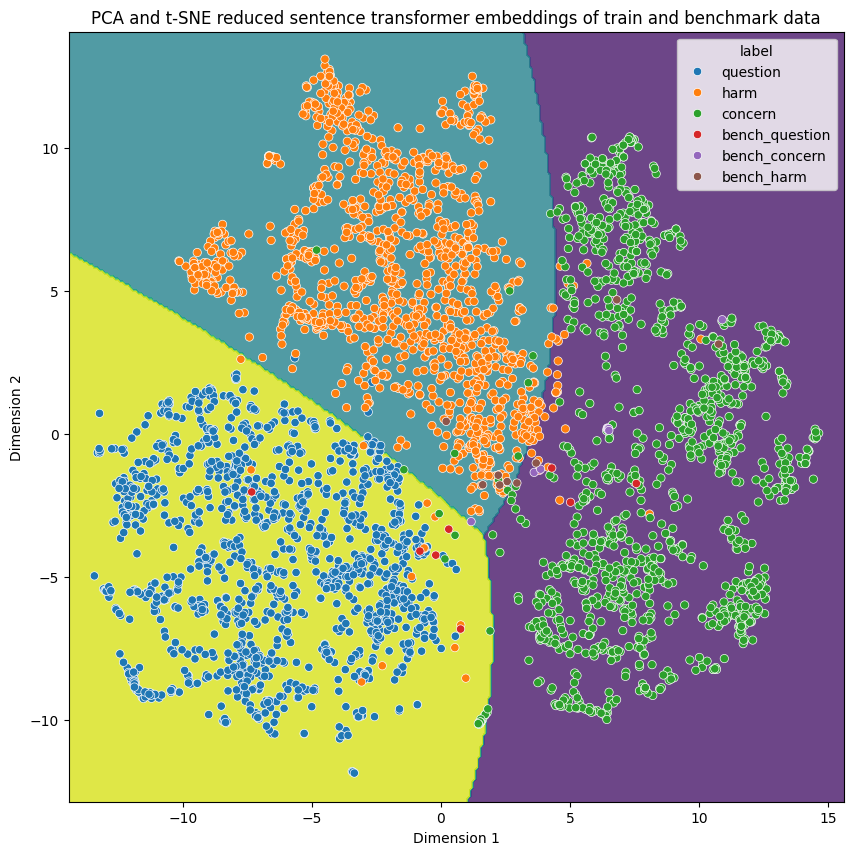

In [57]:
df_tsne, (xx, yy, Z) = tsne_reduction(pd.concat([df_train, df_benchmark.assign(label="bench_" + df_benchmark['label'])]))

# plot
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, alpha=0.8)
sns.scatterplot(df_tsne, x="dim1", y="dim2", hue="label")
plt.title('PCA and t-SNE reduced sentence transformer embeddings of train and benchmark data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [56]:
#TODO bench dataset soll näher an realität sein

# Approach #1: TF-IDF / SVM (Alex)
Introduction?

## Model Architecture
Visualization

## Why we chose this architecture
Why is this architecture suited for this task? Possible drawbacks? Advantages?

In [10]:
#TODO Training / Quantitative evaluation / qualitative evaluation

## Results
Model results / How could model be improved

# Approach #2: LSTM (Tobias)
Introduction?

## Model Architecture
Visualization

## Why we chose this architecture
Why is this architecture suited for this task? Possible drawbacks? Advantages?

In [6]:
def load_data():
    print("loading and preprocessing datasets...")

    df_train = pd.read_parquet("data/train.parquet")
    df_test = pd.read_parquet("data/test.parquet")

    #drop duplicates
    df_train.drop_duplicates(inplace=True)
    df_test.drop_duplicates(inplace=True)

    #drop intersections from test set
    df_test.drop(df_test[df_test.text.isin(np.intersect1d(df_train.text.values, df_test.text.values))].index, inplace=True)

    print("Duplicates in train df: ", df_train.text.duplicated().sum())
    print("Duplicates in test df: ", df_test.text.duplicated().sum())

    print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
    print("Length of train set: ", len(df_train))
    print("Length of test set: ", len(df_test))

    return df_train, df_test

def prepare_loaders(df_train:pd.DataFrame, df_test:pd.DataFrame, tokenizer:str, train_batch_size:int, max_token_length:int=256, train_val_split_ratio:float=0.8, seed:int=1234):
    df_train, df_val = TextClassificationDataset.stratified_random_sampling(df_train, train_val_split_ratio, "label", seed)

    #Dataset and loader
    train_set = TextClassificationDataset(df_train, tokenizer, max_length=max_token_length)
    val_set = train_set.dataset_from_self(df_val)
    test_set = train_set.dataset_from_self(df_test)
    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=len(val_set))
    test_loader = DataLoader(test_set, batch_size=len(test_set))

    return train_loader, val_loader, test_loader, train_set.label_encoder.classes_

def train():
    wandb.init()

    PARAMS:dict = wandb.config

    df_train, df_test = load_data() #load and preprocess data
    train_loader, val_loader, test_loader, classes = prepare_loaders(
        df_train, 
        df_test, 
        PARAMS["embedding_source"], 
        PARAMS["train_batch_size"], 
        PARAMS["max_token_length"], 
        PARAMS["train_val_split_ratio"], 
        PARAMS["val_split_seed"]
    ) #prepare dataloaders

    PARAMS["classes"] = classes #add classes to params

    model = CNNLSTMModel(**PARAMS) #get model
    logger = WandbLogger(entity="t_buess", project="chatbot-classification", log_model=True)
    logger.watch(model, log="all")

    #callbacks
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, mode="min")
    conf_matrix_callback = ChartLogger()

    trainer = Trainer(devices=1, accelerator="gpu", logger=logger, log_every_n_steps=5, max_epochs=PARAMS["max_epochs"], callbacks=[early_stop_callback, conf_matrix_callback])
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(ckpt_path="best", dataloaders=test_loader)

    #get best validation loss from early stopping callback and log it as 'best_val_loss'
    best_val_loss = early_stop_callback.state_dict()["best_score"] 
    wandb.log({"best_val_loss":best_val_loss}) #log best validation loss

    wandb.finish()

class TextClassificationDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, tokenizer:str, text_col:str="text", label_col:str="label", max_length:int=128):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer) #load and store tokenizer
        self.data = dataframe #copy dataframe
        self.max_length = max_length #max token count
        self.text_col = text_col #store text col
        self.label_col = label_col #store label col
        self.label_encoder = LabelEncoder().fit(self.data[self.label_col]) #create and fit label encoder

        self.encode_labels()
        self.tokenize_text()
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()} #get respective entry from input_ids, token_type_ids, attention_mask
        item['labels'] = self.labels[idx] #add label
        return item

    def __len__(self):
        return len(self.labels)

    def tokenize_text(self):
        #tokenize text
        self.encodings = self.tokenizer(
            list(self.data[self.text_col]), 
            truncation=True, 
            padding=True, 
            max_length=self.max_length, 
            return_tensors="pt",
            add_special_tokens=False, #remove special tokens
            return_overflowing_tokens=True #keep overflowing tokens
        )

        if "overflowing_tokens" in self.encodings:
            print("Tokenizer truncated inputs... increase 'max_length'")

    def encode_labels(self):
        #encode labels
        self.labels = torch.tensor(self.label_encoder.transform(self.data[self.label_col]))

    def dataset_from_self(self, dataframe:pd.DataFrame):
        copy_dataset = copy(self) #create a copy of itself

        copy_dataset.data = dataframe #override data
        copy_dataset.tokenize_text() #tokenize new text
        copy_dataset.encode_labels() #encode new labels

        return copy_dataset

    @staticmethod
    def stratified_random_sampling(dataframe:pd.DataFrame, train_size:float, ref_col:str, seed:int=None):
        # Stellen Sie sicher, dass train_size einen gültigen Wert hat
        if not 0 < train_size < 1:
            raise ValueError("train_size must be between 0 and 1")
        
        # Gruppieren des DataFrames nach der Referenzspalte und Anwenden der Sample-Methode auf jede Gruppe, Entfernen der zusätzlichen Indexebene, die durch groupby erzeugt wird
        train_df = dataframe.groupby(ref_col).apply(lambda x: x.sample(frac=train_size, random_state=seed)).reset_index(ref_col, drop=True, inplace=False)
        
        # Finden der Indexe, die nicht in der Trainingsstichprobe ausgewählt wurden
        val_idx = dataframe.index.difference(train_df.index)
        
        # Erstellen des Validierungs-DataFrames
        val_df = dataframe.loc[val_idx]
        
        return (train_df.reset_index(drop=True, inplace=False), val_df.reset_index(drop=True, inplace=False))

class CNNLSTMModel(pl.LightningModule):    
    def __init__(self, embedding_source, num_filters:int, hidden_size:int, classes:list, learning_rate:float, embedding_size:int=None, **kwargs):
        super().__init__()

        self.learning_rate = learning_rate
        self.classes = classes

        # Prüfen, ob embedding_source ein String ist, d.h. der Name eines vorab trainierten Modells
        if isinstance(embedding_source, str):
            model = AutoModel.from_pretrained(embedding_source)
            pretrained_embedding_weight = model.embeddings.word_embeddings.weight

            #create embedding layer
            self.embedding = nn.Embedding(num_embeddings=pretrained_embedding_weight.size(0), embedding_dim=pretrained_embedding_weight.size(1))
            
            # Ersetzen Sie die Gewichte des Embedding-Layers mit den vortrainierten Gewichten
            self.embedding.weight = nn.Parameter(pretrained_embedding_weight)

            # Freeze the pretrained embedding layer
            self.embedding.weight.requires_grad = False

            #override existing embedding size so its displayed correctly in wandb
            embedding_size = self.embedding.embedding_dim

        elif isinstance(embedding_source, int):
            self.embedding = nn.Embedding(num_embeddings=embedding_source, embedding_dim=embedding_size)
        else:
            raise Exception("embedding_source must be from type str or int")

        # Restliche Modellarchitektur
        self.conv1d = nn.Conv1d(in_channels=embedding_size, out_channels=num_filters, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_size, batch_first=True)
        self.dense = nn.Linear(in_features=hidden_size, out_features=len(self.classes))

        self.save_hyperparameters()

    def forward(self, x, attention_mask=None):
        x = self.embedding(x) #embed tokens
        x = x.permute(0, 2, 1) #change order of dimensions for conv
        x = self.conv1d(x) #apply conv
        x = F.leaky_relu(x) #apply non linearity
        x = x.permute(0, 2, 1) #change order for lstm

        #prepare x for lstm if attention_mask != None
        if attention_mask is not None:
            # calculate the length of each sequence in the batch
            seq_lengths = attention_mask.sum(dim=1)
            # pack the sequences
            x = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
            
        x, _ = self.lstm(x) #apply lstm

        #if packed sequence -> unpack
        if attention_mask is not None:
            x, seq_lengths = pad_packed_sequence(x, batch_first=True) # unpack sequence
            seq_lengths = seq_lengths.unsqueeze(-1).to(x.device) #reshape

            x = torch.sum(x, dim=1) / seq_lengths # global average pooling

        else:
            x = torch.mean(x, dim=1)  # global average pooling

        x = self.dense(x) #final dense layer

        return x #return logits
 
    def training_step(self, batch, batch_idx):
        # Extrahieren Sie die Eingaben, Labels und die Attention Mask aus dem Batch
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        # Rufen Sie die Methode forward auf, um die Logits zu erhalten
        logits = self.forward(inputs, attention_mask)

        loss = F.cross_entropy(logits, targets)
        
        # Optional: Loggen Sie den Trainingsverlust
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        logits = self(inputs, attention_mask)
        preds = logits.argmax(dim=1)

        loss = F.cross_entropy(logits, targets)
        acc = balanced_accuracy_score(targets.cpu().tolist(), preds.cpu().tolist())
        f1_macro = f1_score(targets.cpu().tolist(), preds.cpu().tolist(), average="macro")

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1_macro', f1_macro, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        logits = self(inputs, attention_mask)
        probas = logits.softmax(dim=1)
        preds = logits.argmax(dim=1)

        loss = F.cross_entropy(logits, targets)
        acc = balanced_accuracy_score(targets.cpu().tolist(), preds.cpu().tolist())
        f1_macro = f1_score(targets.cpu().tolist(), preds.cpu().tolist(), average="macro")

        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.log('test_f1_macro', f1_macro, prog_bar=True)

        return {"preds": preds, "probas": probas}

    def predict(self, text:str, tokenizer:BertTokenizerFast, max_token_length:int=512):
        tokenized = tokenizer(
            [text],
            truncation=True,
            padding=False,
            max_length=max_token_length,
            return_tensors="pt",
            add_special_tokens=False #remove special tokens

        )['input_ids'].to(self.device) #tokenize text and send to device

        pred = self(tokenized, None).argmax(dim=1)[0] #predict class

        return self.classes[pred] #map number to label
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

class ChartLogger(pl.Callback):
    def __init__(self) -> None:
        super().__init__()

        self.preds = []
        self.probas = []
        self.targets = []

    def on_test_batch_end(self, trainer, pl_module:CNNLSTMModel, outputs, batch, batch_idx) -> None:
        preds = outputs["preds"]
        probas = outputs["probas"]
        targets = batch['labels']

        self.preds.extend(preds.cpu().tolist())
        self.probas.extend(probas.cpu().tolist())
        self.targets.extend(targets.cpu().tolist())

    def on_test_epoch_end(self, trainer, pl_module:CNNLSTMModel):
        # Log the confusion matrix
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
            preds=self.preds, y_true=self.targets, class_names=pl_module.classes)
        })

        # Log the roc curve
        wandb.log({"roc_curve": wandb.plot.roc_curve(
            y_probas=self.probas, y_true=self.targets, labels=pl_module.classes)
        })

        # Clear for the next epoch
        self.preds = []
        self.probas = []
        self.targets = []

In [ ]:
##train model in a sweep
sweep_config = {
    "method": "grid",
    "name": "test sweep",
    "metric": {
        "goal": "minimize",
        "name": "best_val_loss"
    },
    "parameters": {
        "embedding_source": {"values": ["dbmdz/bert-base-german-cased"]},
        "num_filters": {"values": [16, 64, 128, 256]},
        "hidden_size": {"values": [16, 64, 128, 256, 512, 1024]},
        "learning_rate": {"values": [1e-5, 1e-6]},
        "train_batch_size": {"values": [32]},
        "max_token_length": {"values": [128]},
        "train_val_split_ratio": {"values": [0.8]},
        "val_split_seed": {"values": [1234]},
        "max_epochs": {"values": [200]}
    }
}

sweep_id = wandb.sweep(sweep_config, entity="t_buess", project="chatbot-classification")
wandb.agent(sweep_id, train)

#TODO Training / Quantitative evaluation / qualitative evaluation

## Results
Model results / How could model be improved

# Approach #3: BERT (Yvo)
Introduction?

## Model Architecture
Visualization

## Why we chose this architecture
Why is this architecture suited for this task? Possible drawbacks? Advantages?

In [12]:
#TODO Training / Quantitative evaluation / qualitative evaluation

## Results
Model results / How could model be improved

# Benchmark on custom dataset (Yvo)

In [13]:
#TODO run all models on this dataset

## Discussion

How did the models perform on the custom dataset